In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [4]:
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Load the dataset

data = np.array(data)

# Split the data into features and labels
X_data = data[:, 0:-1]
y_data = data[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

In [7]:
class CreditCardTrainDataLoader(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(X_train).float()
        self.y_data = torch.from_numpy(y_train).float()
        self.len = X_train.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

class CreditCardTestDataLoader(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(X_test).float()
        self.y_data = torch.from_numpy(y_test).float()
        self.len = X_test.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [8]:
batch_size = 50

data_set = CreditCardTrainDataLoader()
train_loader = DataLoader(
    dataset=data_set,
    batch_size=batch_size,
    shuffle=True
)

test_data_set = CreditCardTestDataLoader()
test_loader = DataLoader(
    dataset=test_data_set,
    batch_size=1,
    shuffle=False
)

In [9]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.sigmoid(out)
        out = self.layer2(out)
        return out

input_dim = 30
hidden_dim = 32
num_of_classes = 2

model = Model(input_dim, hidden_dim, num_of_classes)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 5

In [10]:
# Lists to store loss and accuracy values
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = Variable(inputs)
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels.long())
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            total = 0
            correct = 0
            for ins, l in test_loader:
                ins = Variable(ins)
                outs = model(ins)
                _, predicted = torch.max(outs.data, 1)

                total += l.size(0)
                correct += (predicted == l.long()).sum().item()

            accuracy = 100 * correct / total
            loss_values.append(loss.item())
            accuracy_values.append(accuracy)

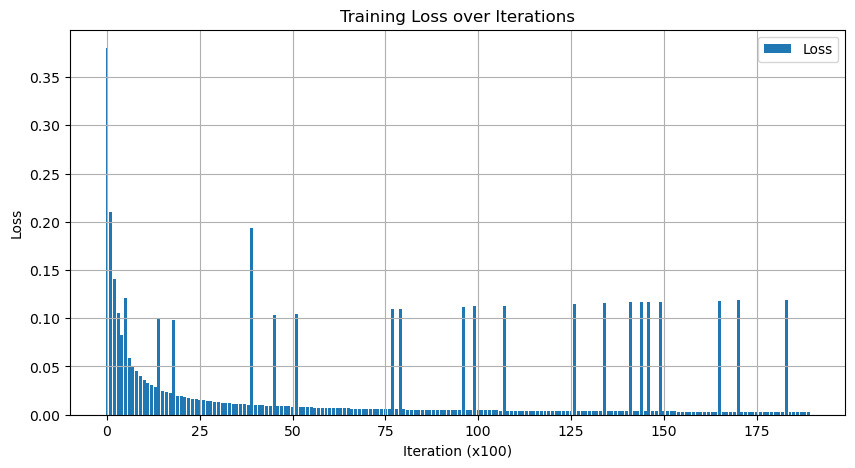

In [11]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(loss_values)), loss_values, label="Loss")
plt.xlabel("Iteration (x100)")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.legend()
plt.grid(True)
plt.savefig("training_loss_bar_chart.png")
plt.show()


In [12]:
fraudulent_count = np.sum(y_data == 1)
normal_count = np.sum(y_data == 0)


Number of fraudulent transactions: 492
Number of normal transactions: 284315


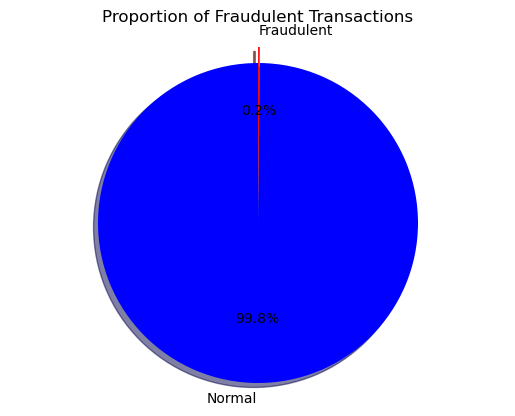

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("creditcard.csv")

# Count the number of fraudulent and normal transactions
fraudulent_count = data[data['Class'] == 1].shape[0]
normal_count = data[data['Class'] == 0].shape[0]

# Print the counts
print(f"Number of fraudulent transactions: {fraudulent_count}")
print(f"Number of normal transactions: {normal_count}")

# Create a pie chart
labels = 'Normal', 'Fraudulent'
sizes = [normal_count, fraudulent_count]
colors = ['blue', 'red']
explode = (0, 0.1)  # explode the 2nd slice (i.e. 'Fraudulent')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Proportion of Fraudulent Transactions')
plt.savefig("fraud_vs_normal_pie_chart.png")
plt.show()

In [14]:
# Generate predictions for the test set
y_pred = []
y_true = []

for inputs, labels in test_loader:
    inputs = Variable(inputs)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.numpy())
    y_true.extend(labels.numpy())


In [15]:
cm = confusion_matrix(y_true, y_pred)

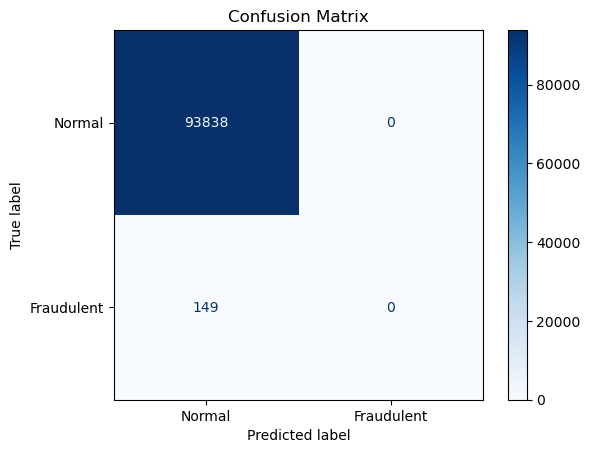

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraudulent'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()